#### The standards and necessaries:

In [1]:
# Import relevant modules
from AtmoBuilder import AtmoBuilder
import matplotlib.pyplot as plt
import numpy as np
from astroML.stats import binned_statistic_2d
#from astroML.plotting.mcmc import convert_to_stdev
#from astroML.decorators import pickle_results

import pandas as pd
pd.options.display.max_columns = 50
% matplotlib inline

In [2]:
ab = AtmoBuilder()

Found 16 MODTRAN files:
Pachon_MODTRAN.10.7sc
Pachon_MODTRAN.11.7sc
Pachon_MODTRAN.12.7sc
Pachon_MODTRAN.13.7sc
Pachon_MODTRAN.14.7sc
Pachon_MODTRAN.15.7sc
Pachon_MODTRAN.16.7sc
Pachon_MODTRAN.17.7sc
Pachon_MODTRAN.18.7sc
Pachon_MODTRAN.19.7sc
Pachon_MODTRAN.20.7sc
Pachon_MODTRAN.21.7sc
Pachon_MODTRAN.22.7sc
Pachon_MODTRAN.23.7sc
Pachon_MODTRAN.24.7sc
Pachon_MODTRAN.25.7sc
MODTRAN files have been read.

Read filter data from LSST software stack.
Filters: ['u', 'g', 'r', 'i', 'z', 'y4']
Read hardware data from LSST software stack.


In [3]:
ab.readAll()

# Read 988 MS stars from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/kurucz/
# Read 849 white dwarfs from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/wDs/
# Read 74 mlt stars from /Users/joachim/lsst/DarwinX86/sims_sed_library/2014.10.06/starSED/mlt/
# Generated 2520 galaxies at redshifts between 0.000000 and 3.000000
# Generated 76 quasars at redshifts between 0.000000 and 7.500000
# Generated 39 sn's at redshifts between 0.000000 and 1.200000 on days ['0', '20', '40']


In [4]:
def convert_to_stdev(logL):
    """
    Given a grid of log-likelihood values, convert them to cumulative
    standard deviation.  This is useful for drawing contours from a
    grid of likelihoods.
    """
    sigma = np.exp(logL, dtype=np.float64) # added dtype

    shape = sigma.shape
    sigma = sigma.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(sigma)[::-1]
    i_unsort = np.argsort(i_sort)

    sigma_cumsum = sigma[i_sort].cumsum()
    sigma_cumsum /= sigma_cumsum[-1]

    return sigma_cumsum[i_unsort].reshape(shape)

In [5]:
def plot_mcmc(traces, labels=None, limits=None, true_values=None,
              fig=None, contour=True, scatter=True,
              levels=[0.683, 0.955], bins=20,
              bounds=[0.08, 0.08, 0.95, 0.95], **kwargs):
    """Plot a grid of MCMC results
    Parameters
    ----------
    traces : array_like
        the MCMC chain traces.  shape is [Ndim, Nchain]
    labels : list of strings (optional)
        if specified, the label associated with each trace
    limits : list of tuples (optional)
        if specified, the axes limits for each trace
    true_values : list of floats (optional)
        if specified, the true value for each trace (will be indicated with
        an 'X' on the plot)
    fig : matplotlib.Figure (optional)
        the figure on which to draw the axes.  If not specified, a new one
        will be created.
    contour : bool (optional)
        if True, then draw contours in each subplot.  Default=True.
    scatter : bool (optional)
        if True, then scatter points in each subplot.  Default=False.
    levels : list of floats
        the list of percentile levels at which to plot contours.  Each
        entry should be between 0 and 1
    bins : int, tuple, array, or tuple of arrays
        the binning parameter passed to np.histogram2d.  It is assumed that
        the point density is constant on the scale of the bins
    bounds : list of floats
        the bounds of the set of axes used for plotting
    additional keyword arguments are passed to scatter() and contour()
    Returns
    -------
    axes_list : list of matplotlib.Axes instances
        the list of axes created by the routine
    """
    # Import here so that testing with Agg will work
    from matplotlib import pyplot as plt

    if fig is None:
        fig = plt.figure(figsize=(8, 8))

    if limits is None:
        limits = [(t.min(), t.max()) for t in traces]

    if labels is None:
        labels = ['' for t in traces]

    num_traces = len(traces)

    bins = [np.linspace(limits[i][0], limits[i][1], bins + 1)
            for i in range(num_traces)]

    xmin, xmax = bounds[0], bounds[2]
    ymin, ymax = bounds[1], bounds[3]

    dx = (xmax - xmin) * 1. / (num_traces - 1)
    dy = (ymax - ymin) * 1. / (num_traces - 1)

    axes_list = []

    for j in range(1, num_traces):
        for i in range(j):
            ax = fig.add_axes([xmin + i * dx,
                               ymin + (num_traces - 1 - j) * dy,
                               dx, dy])

            if scatter:
                plt.scatter(traces[i], traces[j], **kwargs)

            if contour:
                H, xbins, ybins = np.histogram2d(traces[i], traces[j],
                                                 bins=(bins[i], bins[j]))

                H[H == 0] = 1E-16
                Nsigma = convert_to_stdev(np.log(H))

                ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
                           0.5 * (ybins[1:] + ybins[:-1]),
                           Nsigma.T, levels=levels, **kwargs)

            if i == 0:
                ax.set_ylabel(labels[j])
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())

            if j == num_traces - 1:
                ax.set_xlabel(labels[i])
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())

            if true_values is not None:
                ax.plot(limits[i], [true_values[j], true_values[j]],
                        ':k', lw=1)
                ax.plot([true_values[i], true_values[i]], limits[j],
                        ':k', lw=1)

            ax.set_xlim(limits[i])
            ax.set_ylim(limits[j])

            axes_list.append(ax)

    return axes_list

#### Creating a sample data set: 

In [6]:
range_Aerosol, range_Alpha, best_Aerosol, best_Alpha, logL = ab.compute_mag_color_nonlinear('Aerosol','Alpha',[1.0,1.0,1.0,1.0,1.2,3.2],1.4,Nbins=50)

AttributeError: AtmoBuilder instance has no attribute 'compute_mag_color_nonlinear'

#### Looking at z filter only (has contours):

In [ ]:
print logL['z'].dtype

In [ ]:
test1 = logL['z'].T
test2 = convert_to_stdev(test1/10000000.)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.contour(test1)
ax.contour(test2)
ax.set_aspect('equal')

In [ ]:
np.savetxt('logL_sample.txt', test1)

In [ ]:
! cat 'logL_sample.txt'

In [ ]:
df1 = pd.DataFrame(test1,index=test1[:,0])
df1

In [ ]:
df2 = pd.DataFrame(test2,index=test2[:,0])
df2

In [ ]:
print test1.min(),test1.max()
print test2.min(),test2.max()

In [ ]:
# Not really necessary
test1matrix = np.matrix(test1)
test2matrix = np.matrix(test2)

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

for i in range(2):
    ax[i].set_aspect('equal')
    ax[i].set_xlabel('Aerosol')
    ax[i].set_ylabel('Alpha')

im1 = ax[0].imshow(test1matrix[::-1], interpolation='nearest', cmap=plt.cm.bone, extent=(0.0,5.0,0.0,5.0))
fig.colorbar(im1, ax=ax[0])
ax[0].set_title(r'Without Standard Deviation Conversion');

im2 = ax[1].imshow(test2matrix[::-1], interpolation='nearest', cmap=plt.cm.bone, extent=(0.0,5.0,0.0,5.0))
fig.colorbar(im2, ax=ax[1])
ax[1].set_title(r'With Standard Deviation Conversion');

In [ ]:
from astroML.datasets import generate_mu_z
from astroML.cosmology import Cosmology
from astroML.plotting.mcmc import convert_to_stdev
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate the data
z_sample, mu_sample, dmu = generate_mu_z(100, z0=0.3,
                                         dmu_0=0.05, dmu_1=0.004,
                                         random_state=1)


#------------------------------------------------------------
# define a log likelihood in terms of the parameters
#  beta = [omegaM, omegaL]
def compute_logL(beta):
    cosmo = Cosmology(omegaM=beta[0], omegaL=beta[1])
    mu_pred = np.array(map(cosmo.mu, z_sample))
    return - np.sum(0.5 * ((mu_sample - mu_pred) / dmu) ** 2)


#------------------------------------------------------------
# Define a function to compute (and save to file) the log-likelihood
@pickle_results('mu_z_nonlinear.pkl')
def compute_mu_z_nonlinear(Nbins=50):
    omegaM = np.linspace(0.05, 0.75, Nbins)
    omegaL = np.linspace(0.4, 1.1, Nbins)

    logL = np.empty((Nbins, Nbins))

    for i in range(len(omegaM)):
        #print '%i / %i' % (i + 1, len(omegaM))
        for j in range(len(omegaL)):
            logL[i, j] = compute_logL([omegaM[i], omegaL[j]])

    return omegaM, omegaL, logL

omegaM, omegaL, res = compute_mu_z_nonlinear()
res -= np.max(res)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

# left plot: the data and best-fit
ax = fig.add_subplot(121)
whr = np.where(res == np.max(res))
omegaM_best = omegaM[whr[0][0]]
omegaL_best = omegaL[whr[1][0]]
cosmo = Cosmology(omegaM=omegaM_best, omegaL=omegaL_best)

z_fit = np.linspace(0.04, 2, 100)
mu_fit = np.asarray(map(cosmo.mu, z_fit))

ax.plot(z_fit, mu_fit, '-k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray')

ax.set_xlim(0, 1.8)
ax.set_ylim(36, 46)

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.text(0.04, 0.96, "%i observations" % len(z_sample),
        ha='left', va='top', transform=ax.transAxes)

# right plot: the likelihood
ax = fig.add_subplot(122)

ax.contour(omegaM, omegaL, convert_to_stdev(res.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')

ax.plot([0, 1], [1, 0], '--k')
ax.plot([0, 1], [0.73, 0.73], ':k')
ax.plot([0.27, 0.27], [0, 2], ':k')

ax.set_xlim(0.05, 0.75)
ax.set_ylim(0.4, 1.1)

ax.set_xlabel(r'$\Omega_M$')
ax.set_ylabel(r'$\Omega_\Lambda$')

plt.show()

In [ ]:
print res.min(), res.max()

In [ ]:
test1ML = res.T
test2ML = convert_to_stdev(res.T)

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.contour(test1ML)
ax.contour(test2ML)
ax.set_aspect('equal')

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

for i in range(2):
    ax[i].set_aspect('equal')
    ax[i].set_xlabel('Aerosol')
    ax[i].set_ylabel('Alpha')

im1 = ax[0].imshow(test1ML[::-1], interpolation='nearest', cmap=plt.cm.bone, extent=(0.0,5.0,0.0,5.0))
fig.colorbar(im1, ax=ax[0])
ax[0].set_title(r'Without Standard Deviation Conversion');

im2 = ax[1].imshow(np.exp(test1ML[::-1]), interpolation='nearest', cmap=plt.cm.bone, extent=(0.0,5.0,0.0,5.0))
fig.colorbar(im2, ax=ax[1])
ax[1].set_title(r'Natural Log of logL')

## DANGER:

Computing nonlinear regression for Aerosol and Alpha.
Observed atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.2, 3.2]
Observed atmosphere airmass:    1.4
Standard atmosphere parameters: [1.0, 1.0, 1.0, 1.0, 1.0, 1.7]
Standard atmosphere airmass:    1.2
Observed atmosphere parameter for Aerosol: 1.2
Observed atmosphere parameter for Alpha: 3.2

@pickle_results: computing results and saving to 'X14_P101010101232_Aerosol_Alpha_XSTD12_DG0_kurucz_u_50bins_TEST.pkl'
Calculating best parameters for u filter...
Completed u filter.
@pickle_results: computing results and saving to 'X14_P101010101232_Aerosol_Alpha_XSTD12_DG0_kurucz_g_50bins_TEST.pkl'
Calculating best parameters for g filter...
Completed g filter.
@pickle_results: computing results and saving to 'X14_P101010101232_Aerosol_Alpha_XSTD12_DG0_kurucz_r_50bins_TEST.pkl'
Calculating best parameters for r filter...
Completed r filter.
@pickle_results: computing results and saving to 'X14_P101010101232_Aerosol_Alpha_XSTD12_DG0_kurucz_i_50bi

AtmoBuilder.py:586: RuntimeWarning: overflow encountered in exp
  return -np.sum(0.5 * np.exp(((dmags_fit[f] - dmags_obs[f]) / err) ** 2))


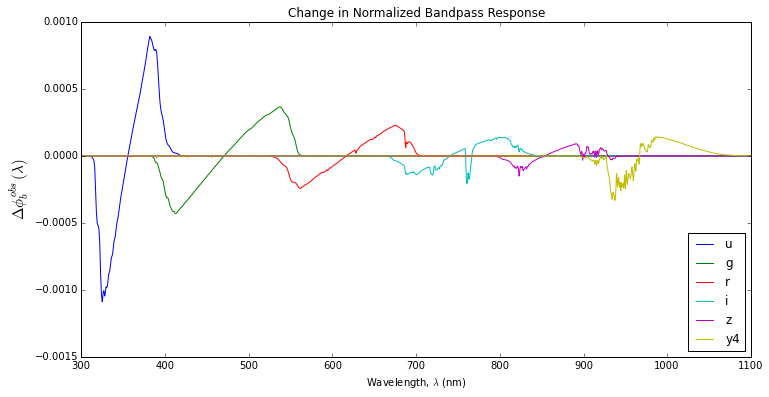

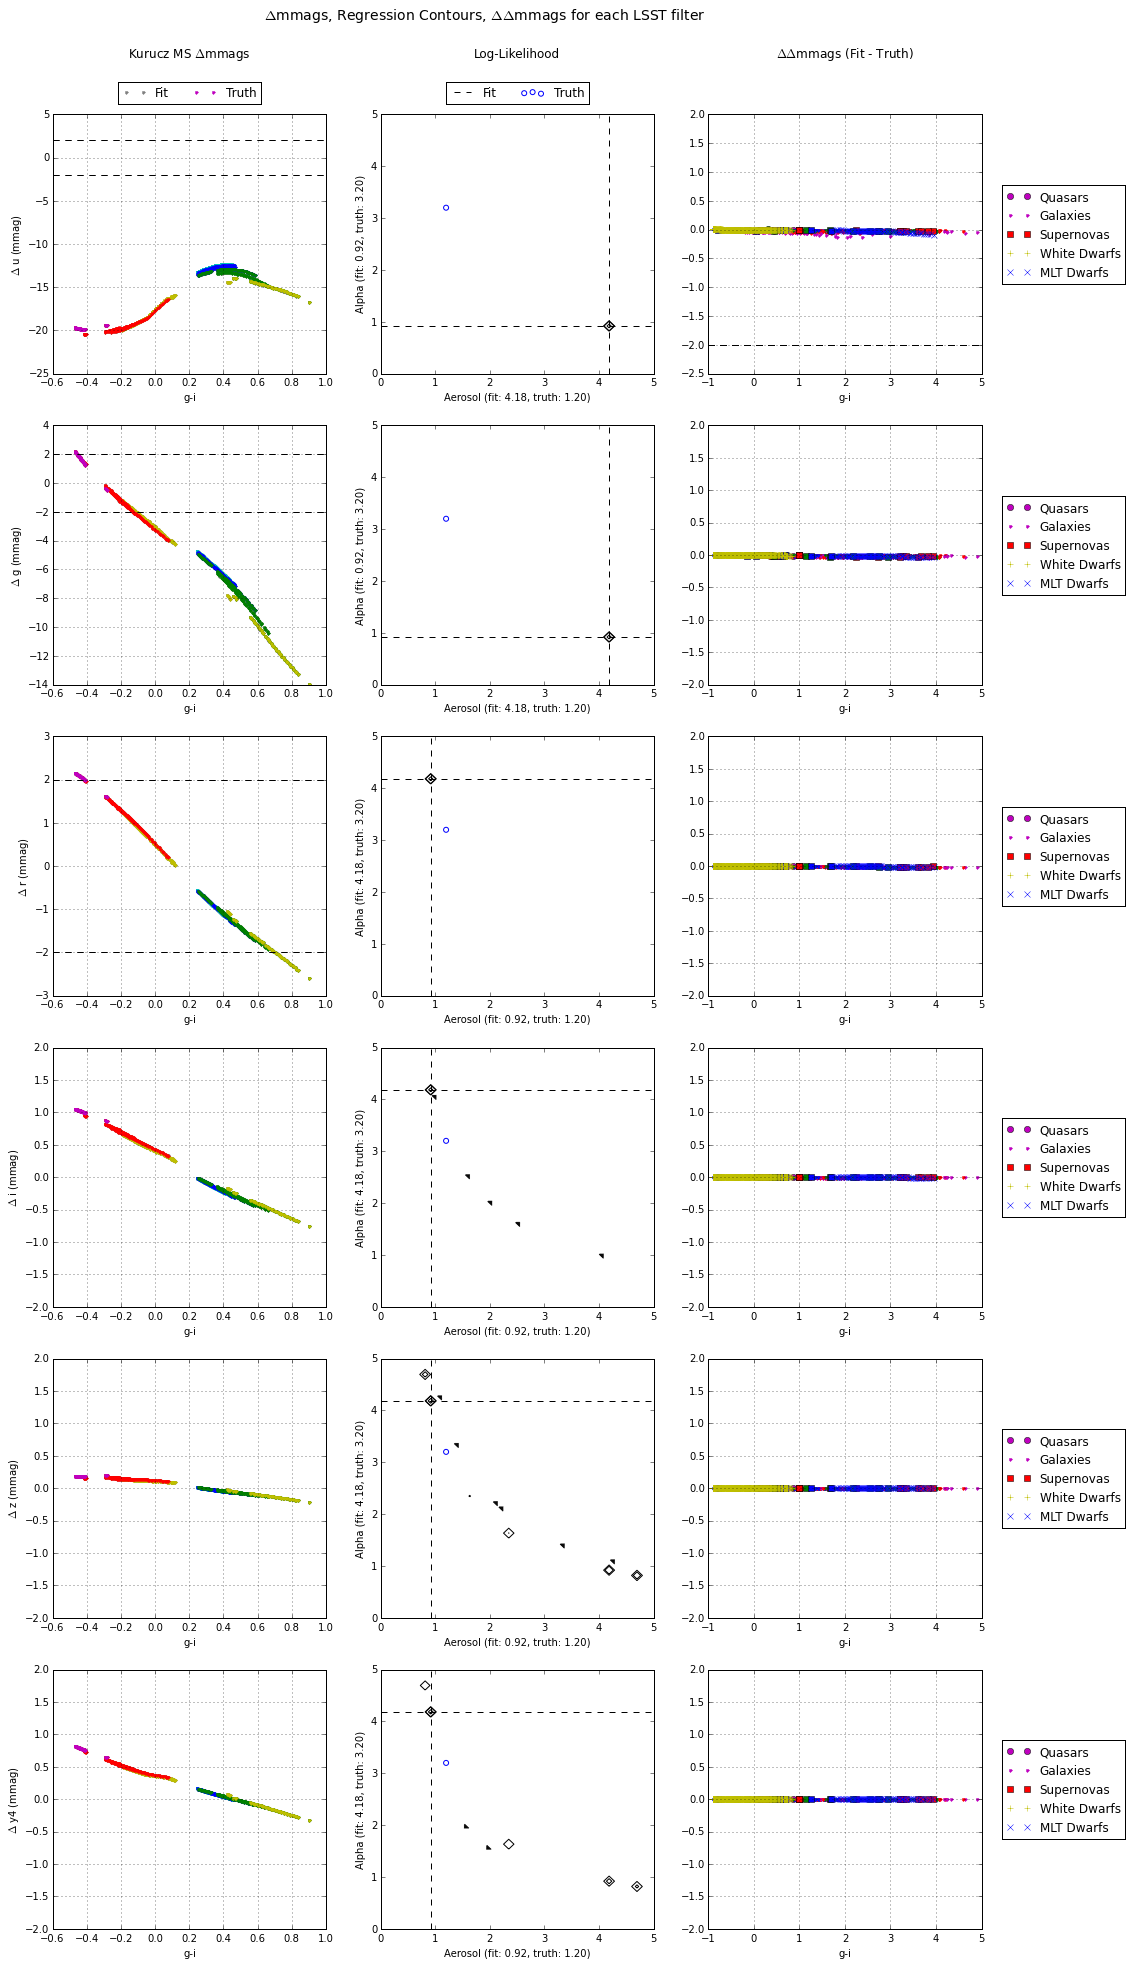

In [7]:
range_Aerosol2, range_Alpha2, best_Aerosol2, best_Alpha2, logL2 = ab.compute_mag_color_nonlinear('Aerosol','Alpha',[1.0,1.0,1.0,1.0,1.2,3.2],1.4,Nbins=50,pickleString='TEST')

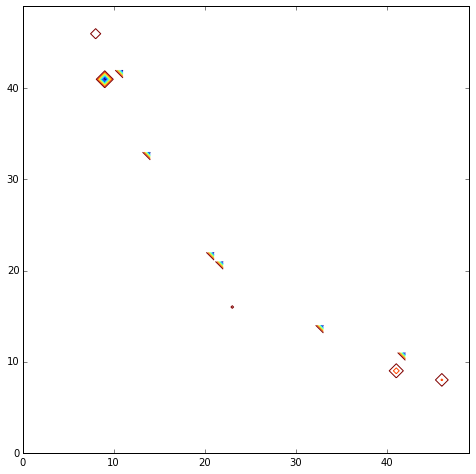

In [8]:
test1 = logL2['z'].T
test2 = convert_to_stdev(test1)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.contour(test1)
ax.contour(test2)
ax.set_aspect('equal')

In [9]:
# Not really necessary
test1matrix = np.matrix(test1)
test2matrix = np.matrix(test2)

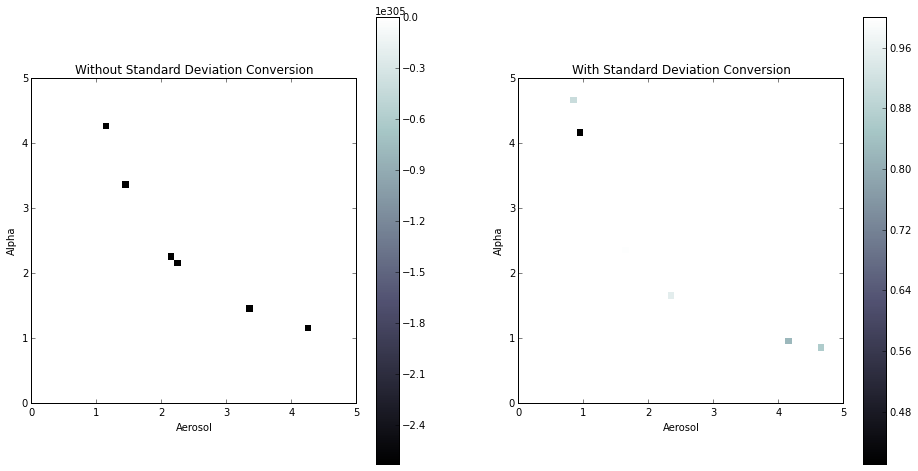

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

for i in range(2):
    ax[i].set_aspect('equal')
    ax[i].set_xlabel('Aerosol')
    ax[i].set_ylabel('Alpha')

im1 = ax[0].imshow(test1matrix[::-1], interpolation='nearest', cmap=plt.cm.bone, extent=(0.0,5.0,0.0,5.0))
fig.colorbar(im1, ax=ax[0])
ax[0].set_title(r'Without Standard Deviation Conversion');

im2 = ax[1].imshow(test2matrix[::-1], interpolation='nearest', cmap=plt.cm.bone, extent=(0.0,5.0,0.0,5.0))
fig.colorbar(im2, ax=ax[1])
ax[1].set_title(r'With Standard Deviation Conversion');

absolute value median instead of 10e6